# Unsupervised Learning and Clustering on 100 days of posts from the 'Type 1 Diabetes' Reddit Thread. 
by Adriana Vesa 


# Problem Statement


We will use unsupervised machine learning to explore data collected from the tyoe 1 reddit thread. Unsupervised machine learning is a class of techniques used to find pattern in data. Tha datagiven to an unsupervised algorithm will not be labeled - which means we will have only an inoiut variable X - and no correspoding varriable.

# Executive Summary


# Table of contents:

Acquiring and Preprocessing Data

Loading Libraries
Loading Data
Model Preparation
Modeling
Baseline Model
Grid Search with a Pipe with Logistic Regression and TFIDF
CountVectorizer in a Pipe with Decision Trees, and Grid Search
Bagging Classifier in a pipe with TFIDF
Naive Bayes with CountVectorizer
Model Selection
Model Evaluation
Conclusion

## Acquiring and Preprocessing Data

## Loading Libraries

In [5]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer


from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV



from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import silhouette_score
matplotlib.style.use('ggplot')


from nltk.stem.snowball import SnowballStemmer

## Loading Data

Below we import the csv file containing the reddit posts collected from the sub-thread - https://www.reddit.com/r/diabetes_t1/ - going back 100 days starting with February 21, 2020. We verify the size of our data - is is a dataframe with 4463 lines and 9 columns.

In [6]:
t1 = pd.read_csv('diabetes_t1_2.csv')
t1.shape

(4463, 9)

We check to see how our dataframe is tructured by checkin its first 5 rows. We decide to create a new column where we add the words of the title - column entitled 'title' - to the words of the post - column entitled 'selftext'- in order to maximize the number of words analyzed. 
We will call this new column 'all_text'.

## Exploratory Data Analysis

In [7]:
t1.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Parents with T1D kids on low carb diet. Any im...,Hi all. My son (7) is t1d and is on a low carb...,diabetes_t1,1582052715,midnightcaller,4,1,True,2020-02-18
1,HBA1C results (2 months since diagnosis),"Diagnosed with type 1 mid December 2019, admit...",diabetes_t1,1582054702,snazehhh,1,1,True,2020-02-18
2,Type 1 diabetes and mood swings,Does anyone here feel that their diabetes can ...,diabetes_t1,1582057153,b-lavender,5,1,True,2020-02-18
3,Bes countries to live in being diabetic,"hello, I wanted to know which are the best cou...",diabetes_t1,1582062986,tiagob94,0,1,True,2020-02-18
4,Best countries to live in being diabetic,"hello, I wanted to know which are the best cou...",diabetes_t1,1582063056,tiagob94,0,1,True,2020-02-18


In [8]:
t1['all_text'] = t1['title']+t1['selftext']

We verify how many of our rows are actually not filled with text, and we drop those rows as they will hinder our analysis. We verify how many rows we have left after this procedure. We see we had to drop 180 rows, and we are left with 4283 posts in good shape to be analyzed. 

In [9]:
t1.isnull().sum()

title             0
selftext        180
subreddit         0
created_utc       0
author            0
num_comments      0
score             0
is_self           0
timestamp         0
all_text        180
dtype: int64

In [10]:
t1.dropna(inplace = True)
t1.shape

(4283, 10)

In [11]:
t1.reset_index(drop=True, inplace = True)

In [12]:
t1.tail()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,all_text
4278,So I was just diagnosed with Rhabdomyolysis,I actually wasn't. But I received a lovely let...,diabetes_t1,1551967031,athomesuperstar,2,14,True,2019-03-07,So I was just diagnosed with RhabdomyolysisI a...
4279,Today marks 30 years,30 years. Not my 30th birthday to be clear. 30...,diabetes_t1,1551971230,KomarKatz,24,120,True,2019-03-07,Today marks 30 years30 years. Not my 30th birt...
4280,"I need help, having lows..........",My doctor recently suggested that I try follow...,diabetes_t1,1551973846,Grammabear2,4,3,True,2019-03-07,"I need help, having lows..........My doctor re..."
4281,Anyone using the Omnipod Dash yet?,My doctor told me some people have received th...,diabetes_t1,1551975353,rchase94,0,1,True,2019-03-07,Anyone using the Omnipod Dash yet?My doctor to...
4282,Experiences with Fiasp,My doctor gave me a sample of Fiasp to try in ...,diabetes_t1,1551979654,zEUjgdWX,6,4,True,2019-03-07,Experiences with FiaspMy doctor gave me a samp...


We will tokenize out text in order for our further analysis to be possible. 
Tokenization is the act of breaking up a sequence of strings into pieces such as words, keywords, phrases, symbols and other elements called tokens. In the process of tokenization, some characters like punctuation marks are discarded. We will keep all our words and numeral symbols, but we will discard symbols, such as punctuation marks and backslashes - since we are interested in keeping only the words in each of the posts we will analyze. First we will import our tokenizer, and then we will aply it on the column that contains the text we wish to analyze.  

In [13]:
tokenizer = RegexpTokenizer(r'\w+')

In [14]:
t1['all_text'] = t1['all_text'].apply(tokenizer.tokenize)

Since the tokenizing process transforms our column of text into a column of lists of "tokens" aka words - as you can see in the cell below - we now need to transform the list back into text. We verify that our code works on the first row of our dataframe:

In [15]:
' '.join(t1['all_text'][0])

'Parents with T1D kids on low carb diet Any impact on growth milestones Hi all My son 7 is t1d and is on a low carb diet It s resulted in great blood sugar control but in the last few check ups he s been falling well behind on height milestones Does anyone have any experience good or bad with this I m concerned the diet may be impacting his development Thanks'

We apply this process to our entire "all_text" column, and we create a column with the text tokenized an ready to be analyzed which we will call "text".

In [16]:
new_texts = t1['all_text']

text_final  = []
for text in new_texts:
    ready = ' '.join(text)
    text_final.append(ready)

t1['text'] = text_final

## Model Preparation

We will create a new dataframe, called X, which will hold only the text to be analized, and we verify it's general structure:

In [17]:
X = t1['text']
X.head()

0    Parents with T1D kids on low carb diet Any imp...
1    HBA1C results 2 months since diagnosis Diagnos...
2    Type 1 diabetes and mood swingsDoes anyone her...
3    Bes countries to live in being diabetichello I...
4    Best countries to live in being diabetichello ...
Name: text, dtype: object

In [18]:
X.shape

(4283,)

Now that we have our data ready to be worked on, we can import a list of stopwords to be eliminated from the text to be analyzed. Also, We decide to eliminate words that will appear in these posts with no necessary impact on the meaning of the posts. Since all these posts have to do with diabetes, we decide to eliminate words such as 
'diabetes', 'insulin', 'blood', 'sugar', 'diabetic". They are words likely to appear in each of the posts we have - and indeed performing an innitial search on our posts they do appear prevalent and will not create proper clustering. We also decided to eliminate words such as 'hi', 'https', 'www', as they are greeting words, or  internet addresses. 


In [19]:
from sklearn.feature_extraction import stop_words

In [27]:
print(stop_words.ENGLISH_STOP_WORDS)

frozenset({'eg', 'many', 'your', 'within', 'for', 'latter', 'upon', 'put', 'bill', 'however', 'hereby', 'he', 'anyone', 'twelve', 'much', 'back', 'none', 'once', 'anyhow', 'six', 'down', 'and', 'are', 'you', 'of', 'in', 'mill', 'least', 'due', 'further', 'indeed', 'cry', 'well', 'nevertheless', 'serious', 'never', 'whence', 'above', 'being', 'some', 'herself', 'amongst', 'amoungst', 'since', 'together', 'she', 'therein', 'still', 'may', 'everyone', 'fifty', 'why', 'sincere', 'behind', 'nor', 'noone', 'nobody', 'someone', 'side', 'whatever', 'is', 'hers', 'describe', 'cannot', 'our', 'co', 'therefore', 'the', 'latterly', 'whereas', 'four', 'themselves', 'whom', 'several', 'them', 'full', 'empty', 'here', 'un', 'myself', 'sixty', 'any', 'both', 'can', 'cant', 'him', 'be', 'towards', 'or', 'into', 'forty', 'becoming', 'while', 'its', 'seems', 'except', 'thence', 'five', 'rather', 'too', 'must', 'less', 'nine', 'whereby', 'seemed', 'former', 'moreover', 'among', 'though', 'beyond', 'always

In [295]:
type(stopwords)

frozenset

In [430]:
stop=set(stopwords)
stop.add('hi')
stop.add('s')
stop.add('m')
stop.add('diabetes')
stop.add('just')
stop.add('insulin')
stop.add('blood')
stop.add('sugar')
stop.add('ve')
stop.add('type')
stop.add('https')
stop.add('com')
stop.add('www')
stop.add('https www')
stop.add('like')
stop.add('don')
stop.add('know')
stop.add('time')
stop.add('years')
stop.add('day')
stop.add('does')
stop.add('going')
stop.add('got')
stop.add('use')
stop.add('using')
stop.add('really')
stop.add('having')
stop.add('diabetic')
stop.add('diagnosed')


We can finaly apply our vectorizers - we decided to try both CountVectorizer and  TfidF - which is short for Term frequency–inverse document frequency - on our cleaned text. As we proceeded and tried both vecorizers - we observed that our unsupervised machine learning works better on our text processed with TfidF. That makes sense as Tfidf practically calculates how relevant a word is in a document - and that is exaclty what we need in our case. We apply Tfidf with the set of stopwords defined above, and we decide to try and find n_grams in the range of 1 to 3, and to keep the maximum features (words that will be appearing in our sparse matrix created by tfidf in our case) to 10000. We will therefore obtain a sparse matrix with 4283 rows and 10000 columns (as we can see in the thris cell bellow). 

In [431]:
tf = TfidfVectorizer(stop_words = stop, ngram_range = (1, 3), max_features = 10000)

In [432]:
train_tf = tf.fit_transform(X)

In [433]:
train_tf.shape

(4283, 10000)

## Modeling - KMeans Clustering


We will be choosing the number of clusters in a K-means model using the silhouette score for our K-menas clusters. The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [165]:
scores_tf =[]
for k in range (5, 50):
    cl_tf = KMeans(n_clusters = k, random_state = 100)
    cl_tf.fit(train_tf)
    inertia = cl_tf.inertia_
    sil = silhouette_score(train_tf, cl_tf.labels_)
    scores_tf.append((k, inertia, sil))

In [214]:
score_tf_t1 = pd.DataFrame(scores_tf, columns = ["k", "inertia", "sil"])
score_tf_t1
score_tf_t1.to_csv('sil_scores', index=False)  

In [300]:
score_tf_t1 = pd.read_csv('sil_scores')

We observe that our silhouette scores are extremely small - we start at 0.03, and we barely get to under 0.007 for  clusters up to 11. 

That informs us that our clusters are not extremely well separated - and indeed considering the topic - there will be overlap between our clusters, the cohesion will be small and the separation will be rather poor too. It is difficult to find a clear demarcation in such a compact thread as one dedicated to a disease  such as type 1 diabetes - as all topics will more or less converge to very similar subjects of interest that can obverlap quite easily. 

Still - we observe above that our sihouette score increases slightly as the number of clusters (k) - and it starts to plateau at around .011 as k = 35. 

We choose a double apporach a conservative one with k = 6 where we  notice the first local maxima at 0.0063, and then a drop in the silhouette score, and then we will take a more expansive approacg - one with k = 30 where  the silhouette score starts to hover at 0.01 - with so many clusters we will go to a very deep, granular level and see more topics of interest in the corpus we are studying. 

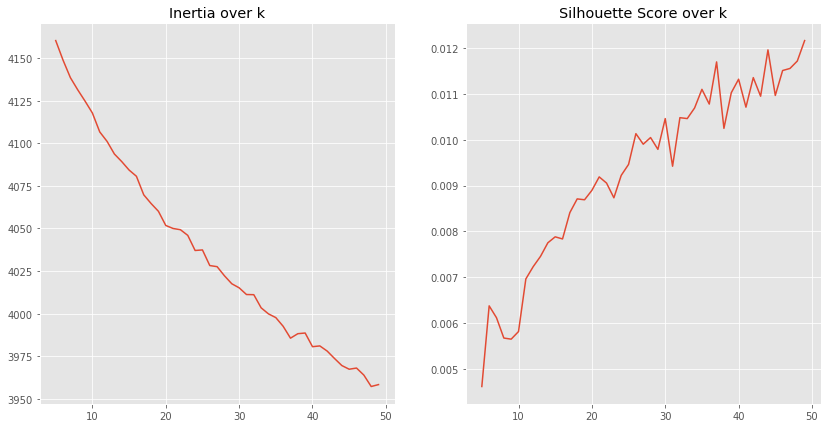

In [301]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_tf_t1.k, score_tf_t1.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_tf_t1.k, score_tf_t1.sil);
axes[1].set_title('Silhouette Score over k');

In the graph above we observe that as we increase our cluster number, k, the silhouette score increases too - although it still is well below 1. We predict there will be a difficult demarcation between our clusters, as the topics will most likely touch on each other. 

FUnction to help calculate distance to the cluster centroid - needs work!

In [1]:
clusters=km_tf_6.fit_predict(train_tf)

centroids = km_tf_6.cluster_centers_
len(centroids[0])

NameError: name 'km_tf_6' is not defined

In [2]:
#needs to loop through 10000 distances not just 2
def k_mean_distance(data, cx, cy, i_centroid, cluster_labels):
        distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[cluster_labels == i_centroid]]
        return distances
    
clusters=km_tf_6.fit_predict(train_tf)
centroids = km_tf_6.cluster_centers_

distances = []
for i, (cx, cy) in enumerate(centroids):
    mean_distance = k_mean_distance(train_tf, cx, cy, i, clusters)
    distances.append(mean_distance)

print(distances)

NameError: name 'km_tf_6' is not defined

## KMeans with 30 clusters

In [131]:
km_tf_30 = KMeans(n_clusters = 30, random_state = 100)
km_tf_30.fit(train_tf)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=100, tol=0.0001, verbose=0)

In [132]:
features30_tf = pd.DataFrame(train_tf.toarray(), columns = tf.get_feature_names())
features30_tf['cluster'] = km_tf_35.labels_
features30_tf.groupby(by = 'cluster').count()

,00,00 pm,000,01,04,05,06,07,08,10,...,youtube,youtube channel,youtube watch,yr,yr old,yrs,yup,zero,zero carb,zone
cluster,,,,,,,,,,,,,,,,,,,,,
0,98,98,98,98,98,98,98,98,98,98,...,98,98,98,98,98,98,98,98,98,98
1,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
2,126,126,126,126,126,126,126,126,126,126,...,126,126,126,126,126,126,126,126,126,126
3,216,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,216,216,216
4,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
5,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052,...,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052
6,152,152,152,152,152,152,152,152,152,152,...,152,152,152,152,152,152,152,152,152,152
7,58,58,58,58,58,58,58,58,58,58,...,58,58,58,58,58,58,58,58,58,58
8,161,161,161,161,161,161,161,161,161,161,...,161,161,161,161,161,161,161,161,161,161


In [133]:
features30_tf.groupby(by = 'cluster').sum().iloc[0].sort_values(ascending = False).head(10)

a1c            23.507839
months          4.087440
endo            4.076373
happy           3.464513
proud           3.313438
went            3.303963
year            2.948829
ago             2.892910
finally         2.208448
appointment     2.144510
Name: 0, dtype: float64

In [134]:
features30_tf.groupby(by = 'cluster').sum().iloc[1].sort_values(ascending = False).head(10)

levels            10.772572
glucose           10.198578
high               5.149052
glucose levels     4.236607
low                3.090178
range              2.626614
normal             2.446281
hba1c              2.316783
days               1.695743
bit                1.638382
Name: 1, dtype: float64

In [135]:
features30_tf.groupby(by = 'cluster').sum().iloc[2].sort_values(ascending = False).head(10)

app            19.472519
dexcom         15.670623
phone           8.422472
watch           7.939112
data            5.568517
apple           5.018672
iphone          4.672802
g6              4.616692
dexcom app      4.589990
apple watch     4.046536
Name: 2, dtype: float64

In [136]:
features30_tf.groupby(by = 'cluster').sum().iloc[3].sort_values(ascending = False).head(10)

diabetics     11.568906
said           9.114258
told           6.508085
people         5.023194
experience     4.613213
thing          4.257159
disease        3.948698
did            3.233639
wondering      3.137712
right          3.121829
Name: 3, dtype: float64

In [137]:
features30_tf.groupby(by = 'cluster').sum().iloc[4].sort_values(ascending = False).head(10)

omnipod         23.350932
pod              8.017936
dash             6.821058
omnipod dash     4.909600
pdm              4.830005
pump             3.245454
getting          1.943879
wondering        1.873730
dexcom           1.760896
skin             1.725153
Name: 4, dtype: float64

In [138]:
features30_tf.groupby(by = 'cluster').sum().iloc[5].sort_values(ascending = False).head(10)

t1d       20.551828
t1        17.635490
help      16.939031
life      16.222776
people    15.689030
good      15.131568
want      14.484655
year      14.016109
thanks    13.818994
feel      13.186714
Name: 5, dtype: float64

In [139]:
features30_tf.groupby(by = 'cluster').sum().iloc[6].sort_values(ascending = False).head(10)

pump              26.177592
cgm                7.833194
medtronic          7.824728
new                4.421176
pumps              4.058835
want               3.876484
pump cgm           3.764392
minimed            3.234442
tandem             3.129830
medtronic pump     2.820580
Name: 6, dtype: float64

In [140]:
features30_tf.groupby(by = 'cluster').sum().iloc[7].sort_values(ascending = False).head(10)

g5                   16.859257
dexcom g5            10.787826
dexcom                8.032620
g6                    3.893271
sensors               3.791321
g5 sensors            3.416302
transmitter           2.428578
g5 transmitter        2.030888
box                   1.847033
dexcom g5 sensors     1.666615
Name: 7, dtype: float64

In [141]:
features30_tf.groupby(by = 'cluster').sum().iloc[8].sort_values(ascending = False).head(10)

basal      16.738482
units       8.402753
dose        8.018140
night       7.139877
lantus      5.532236
spike       5.505120
bolus       5.370069
hours       4.938370
morning     4.759895
low         3.994166
Name: 8, dtype: float64

In [142]:
features30_tf.groupby(by = 'cluster').sum().iloc[9].sort_values(ascending = False).head(10)

bg       19.523610
high      3.513874
low       2.148995
range     2.108608
night     2.060473
hours     1.834638
bed       1.799692
meter     1.590543
good      1.503534
woke      1.479410
Name: 9, dtype: float64

In [143]:
features30_tf.groupby(by = 'cluster').sum().iloc[10].sort_values(ascending = False).head(10)

weight         17.159099
lose            4.556260
lose weight     4.483606
gain            3.892502
exercise        2.894523
loss            2.579035
weight loss     2.547846
losing          2.444538
fat             2.323528
gain weight     2.185330
Name: 10, dtype: float64

In [144]:
features30_tf.groupby(by = 'cluster').sum().iloc[11].sort_values(ascending = False).head(10)

pump            18.229025
injections       3.964991
getting          3.240759
sites            2.872617
help             2.393985
tslim            2.373878
getting pump     2.292723
thinking         2.285836
site             2.236236
wondering        2.223020
Name: 11, dtype: float64

In [145]:
features30_tf.groupby(by = 'cluster').sum().iloc[12].sort_values(ascending = False).head(10)

x2                9.830582
slim              9.673684
tandem            8.292570
pump              6.821950
slim x2           6.498442
tslim             4.384094
tslim x2          4.017479
tandem slim       3.548409
tandem slim x2    2.317810
autosoft          2.216314
Name: 12, dtype: float64

In [146]:
features30_tf.groupby(by = 'cluster').sum().iloc[13].sort_values(ascending = False).head(10)

medtronic         10.431942
670g               5.021182
miao               4.963100
cgm                4.729517
medtronic 670g     3.390385
pumps              2.769791
pump               2.474910
miao miao          2.402462
670                2.386018
old medtronic      1.952428
Name: 13, dtype: float64

In [147]:
features30_tf.groupby(by = 'cluster').sum().iloc[14].sort_values(ascending = False).head(10)

supplies         18.232814
pump supplies     5.162534
pump              4.014768
reservoirs        3.100229
medtronic         2.949006
need              2.898844
insurance         2.764277
help              2.199331
free              2.103737
people            1.953820
Name: 14, dtype: float64

In [148]:
features30_tf.groupby(by = 'cluster').sum().iloc[15].sort_values(ascending = False).head(10)

eat        18.227322
carbs      15.903686
hours       8.961902
units       7.848526
high        7.394692
eating      7.270413
morning     7.260363
food        6.978733
went        6.937570
meal        6.589918
Name: 15, dtype: float64

In [149]:
features30_tf.groupby(by = 'cluster').sum().iloc[16].sort_values(ascending = False).head(10)

g6             22.464341
dexcom         17.705435
dexcom g6      15.639441
sensors         5.794959
transmitter     4.139358
sensor          3.865534
receiver        3.302670
g6 sensors      2.874184
need            2.854798
signal          2.679406
Name: 16, dtype: float64

In [150]:
features30_tf.groupby(by = 'cluster').sum().iloc[17].sort_values(ascending = False).head(10)

carb             15.863680
low carb         10.392942
low               8.160570
diet              4.855304
carb diet         4.352489
low carb diet     3.877779
carbs             3.465207
eat               3.075678
carb ratio        2.494822
meals             2.471193
Name: 17, dtype: float64

In [151]:
features30_tf.groupby(by = 'cluster').sum().iloc[18].sort_values(ascending = False).head(10)

humalog      10.697417
novolog       8.521648
fiasp         7.664697
pens          7.149822
tresiba       3.960924
lantus        3.175726
vial          3.169617
need          2.871009
extra         2.841749
insurance     2.685916
Name: 18, dtype: float64

In [152]:
features30_tf.groupby(by = 'cluster').sum().iloc[19].sort_values(ascending = False).head(10)

amp                 21.732666
amp x200b           17.219375
x200b               17.219375
redd                 3.628267
png                  2.486240
amp x200b thanks     2.104380
x200b thanks         2.104380
jpg                  2.082368
t1                   1.943578
pump                 1.934726
Name: 19, dtype: float64

In [153]:
features30_tf.groupby(by = 'cluster').sum().iloc[20].sort_values(ascending = False).head(10)

low        29.687401
high       20.474227
feel       15.729224
sugars      9.263297
lows        7.901637
feeling     7.456463
sleep       6.275856
hypo        4.897353
bad         4.819686
night       4.692381
Name: 20, dtype: float64

In [154]:
features30_tf.groupby(by = 'cluster').sum().iloc[21].sort_values(ascending = False).head(10)

study                 5.205644
survey                3.249334
forms                 2.178140
qualtrics             2.031424
qualtrics jfe         1.921585
jfe form              1.921585
jfe                   1.921585
qualtrics jfe form    1.921585
form                  1.897089
research              1.643729
Name: 21, dtype: float64

In [155]:
features30_tf.groupby(by = 'cluster').sum().iloc[22].sort_values(ascending = False).head(10)

strips         11.554020
test strips     7.872299
test            7.512405
meter           3.355421
need            1.566882
freestyle       1.400728
contour         1.288007
boxes           1.187644
needs           1.143655
lancets         1.130305
Name: 22, dtype: float64

In [156]:
features30_tf.groupby(by = 'cluster').sum().iloc[23].sort_values(ascending = False).head(10)

sensor         37.986556
dexcom          7.602043
new             6.974384
transmitter     6.865880
sensors         6.526063
guardian        6.308302
new sensor      5.221340
g6              5.194372
days            4.397238
g6 sensor       4.236066
Name: 23, dtype: float64

In [157]:
features30_tf.groupby(by = 'cluster').sum().iloc[24].sort_values(ascending = False).head(10)

removed            18.021353
types               1.142058
benefits            1.079834
symptoms            1.062118
symptoms amp        0.943327
causes symptoms     0.943327
treatment           0.864573
nephropathy         0.828745
counteract          0.822491
remedy              0.811978
Name: 24, dtype: float64

In [159]:
features30_tf.groupby(by = 'cluster').sum().iloc[25].sort_values(ascending = False).head(10)

libre              25.117657
freestyle          19.802736
freestyle libre    16.306995
sensor              6.133533
sensors             4.063392
libre sensor        3.627133
dexcom              3.046641
reader              2.808257
uk                  2.620385
arm                 2.360353
Name: 25, dtype: float64

In [160]:
features30_tf.groupby(by = 'cluster').sum().iloc[26].sort_values(ascending = False).head(10)

drink               8.201686
alcohol             7.226463
drinking            6.239487
drinks              4.475251
water               2.893261
guys                1.347134
eat                 1.264559
low                 1.184978
good                1.170235
drinking alcohol    1.164759
Name: 26, dtype: float64

In [161]:
features30_tf.groupby(by = 'cluster').sum().iloc[27].sort_values(ascending = False).head(10)

infusion         12.023135
site              8.349117
sets              5.972975
infusion sets     5.211657
infusion set      4.119408
cannula           3.850500
set               3.766203
sites             3.730818
pump              3.549696
medtronic         3.128047
Name: 27, dtype: float64

In [162]:
features30_tf.groupby(by = 'cluster').sum().iloc[28].sort_values(ascending = False).head(10)

iq            11.525950
control iq     9.150376
control        6.069297
basal          3.465456
tandem         3.370544
basal iq       3.240006
pump           1.631711
x2             1.584004
software       1.352146
update         1.314328
Name: 28, dtype: float64

In [163]:
features30_tf.groupby(by = 'cluster').sum().iloc[29].sort_values(ascending = False).head(10)

insurance           27.126057
month                4.979005
coverage             4.852329
health               4.583260
dexcom               4.395380
order                4.327564
health insurance     4.253649
company              3.876728
afford               3.558251
pay                  3.533922
Name: 29, dtype: float64